<a href="https://colab.research.google.com/github/Taejin1221/Lab_Experiment/blob/main/Trajectory_Clustering/Trajectory_Clustering_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [1]:
import os, cv2, glob
import numpy as np
import pandas as pd

'''
If you want to know this file,
refer to https://github.com/smupilab/Trajectory-AE/blob/master/utils/convertImage.py
'''
from drive.MyDrive.University.PiLab.Experiment.Codes import convertImage as utils
import matplotlib.pyplot as plt

# Set Constants

In [2]:
# Constants
WIDTH, HEIGHT = 256, 256

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring',
    'number' : '14',
    'date' : '05-24-2021',
    'description' : 'Cosine Similarity Threshold를 0.3으로 늘려서 실험\n'
    }

ROOT_DIR = os.path.join('/content', 'drive','MyDrive','University','PiLab','Experiment' )
DATA_DIR = os.path.join( ROOT_DIR, 'Data', 'Trajectory_virtual_data')
RESULT_DIR = os.path.join( ROOT_DIR, 'Results')

plt.gray()

<Figure size 432x288 with 0 Axes>

# Load and Preprocessing Data

## Convert CSV to Image

In [3]:
os.chdir( DATA_DIR )

files = glob.glob( '*csv' )

generator = utils.Map2ImageGenerator( WIDTH, HEIGHT, 0 )

images = [ ]
for file in files:
    csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )

    images.append( generator.ConvertImage( csv_file ) )

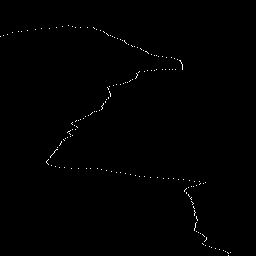

In [4]:
from google.colab.patches import cv2_imshow

cv2_imshow( images[0] )

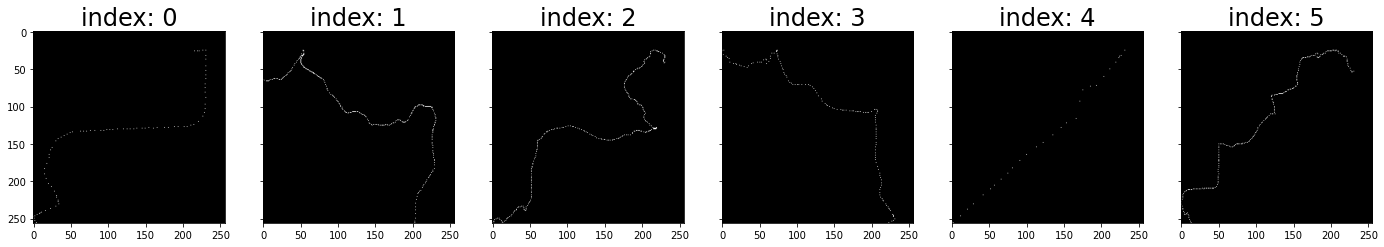

In [5]:
# plt.gray()

# ( 0, 2 )
# ( 1, 3 )
# ( 4, 5 )

test_images = [ images[-13], images[-12], images[-11], images[-8], images[-7], images[-1] ]

n = len( test_images )
fig, ax = plt.subplots( 1, n, True, True, figsize = ( n * 4, 16 ) )
for i in range( n ):
    ax[i].set_title( f'index: {i}', fontsize = 24 )
    ax[i].imshow( test_images[i] )

plt.savefig( 'Index_images.png', dpi = 100 )
plt.show()

## Crop Image

In [6]:
CROP_WIDTH, CROP_HEIGHT = 32, 32

cropped_images_train, matching = [ ], [ ]
for image in images:
    matching.append( len( cropped_images_train ) )
    for i in range( 0, HEIGHT, CROP_HEIGHT ):
        for j in range( 0, WIDTH, CROP_WIDTH ):
            curr_image = [ ]
            for ii in range( i, i + CROP_HEIGHT ):
                curr_image.append( image[ii][j : j + CROP_WIDTH] )
            cropped_images_train.append( curr_image )

cropped_images_test = [
              cropped_images_train[matching[-13] : matching[-12]],
              cropped_images_train[matching[-12] : matching[-11]],
              cropped_images_train[matching[-11] : matching[-10]],
              cropped_images_train[matching[-8] : matching[-7]],
              cropped_images_train[matching[-7] : matching[-6]],
              cropped_images_train[matching[-1] : ]
              ]

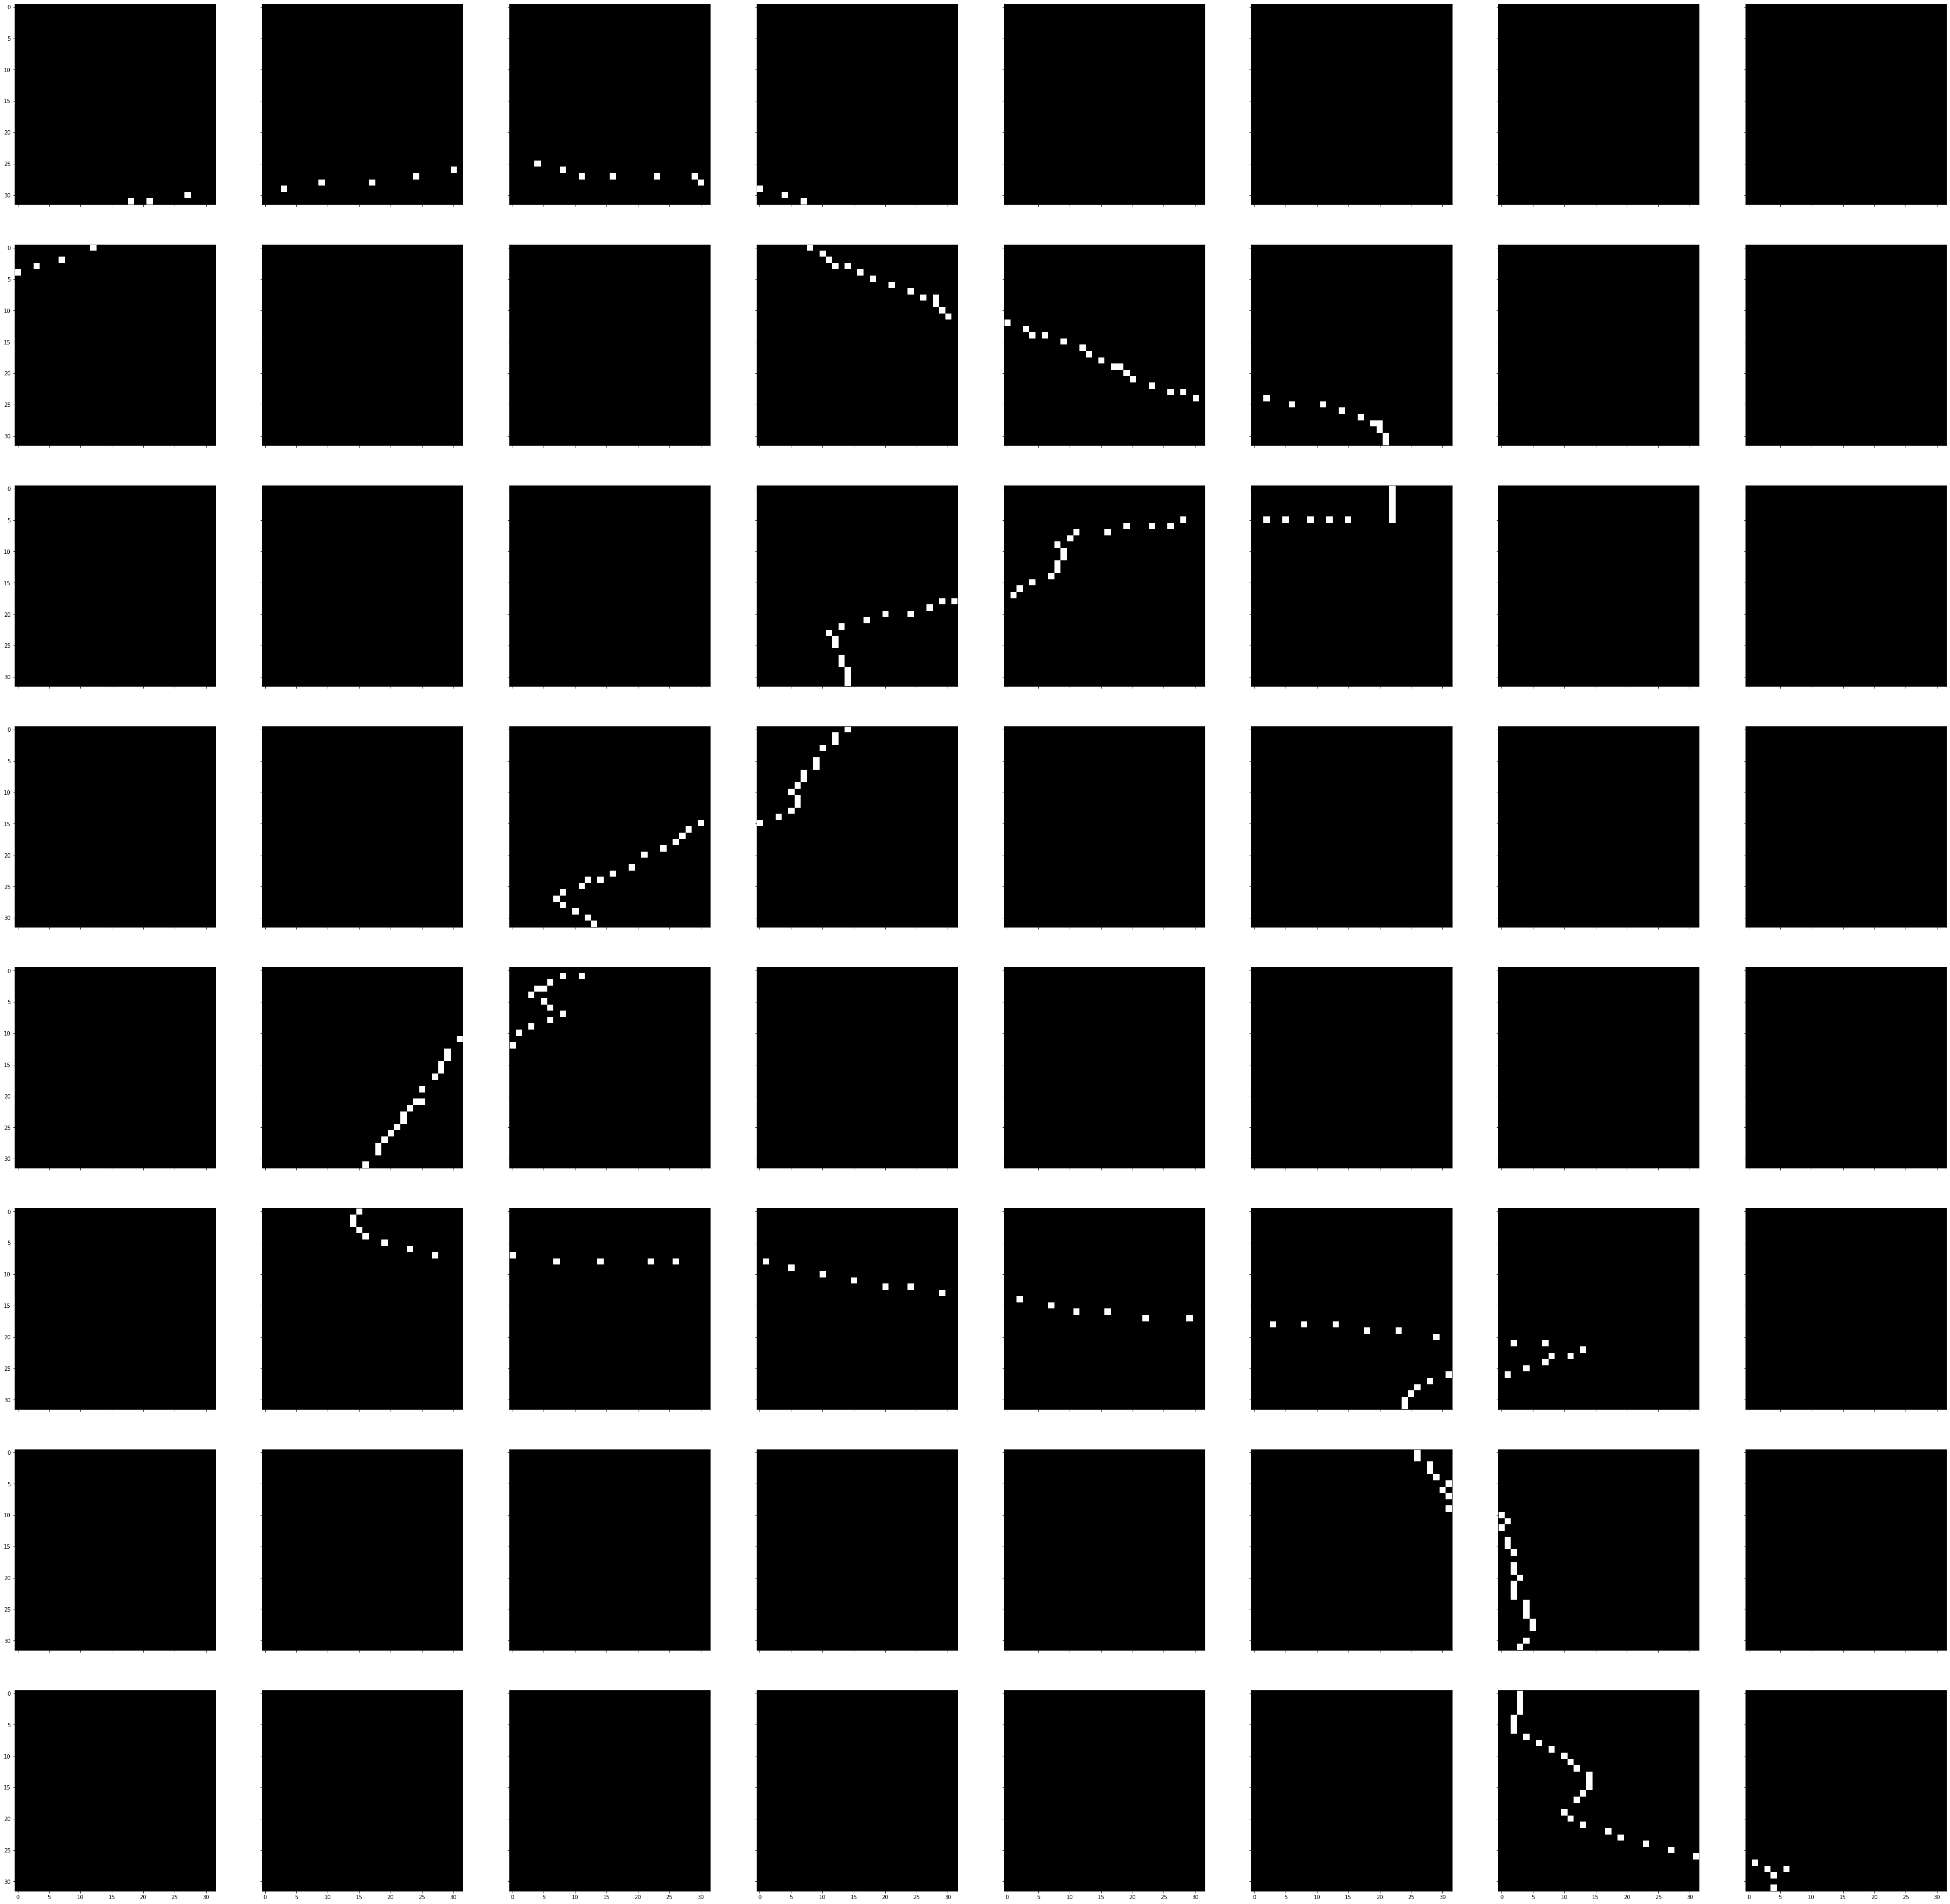

In [7]:
row, col = HEIGHT // CROP_HEIGHT, WIDTH // CROP_WIDTH
fig, ax = plt.subplots( row, col, True, True, figsize = ( 64, 64 ) )
for i in range( row * col ):
    ax[i // row][i % col].imshow( cropped_images_train[i] )
plt.show()

In [8]:
print( len(cropped_images_train) )

4224


In [9]:
X_train = np.array( cropped_images_train ).astype( 'float32' ) / 255.
X_train = np.reshape( X_train, ( -1, CROP_HEIGHT, CROP_WIDTH, 1 ) )

X_test = np.array( cropped_images_test ).astype( 'float32' ) / 255.
X_test = np.reshape( X_test, ( -1, CROP_HEIGHT, CROP_WIDTH, 1 ) )

In [10]:
print( X_train.shape, X_test.shape )

(4224, 32, 32, 1) (384, 32, 32, 1)


# Construct AE Model

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
af, pd = 'relu', 'same' # activation function adn padding value

encode_input = layers.Input( ( CROP_HEIGHT, CROP_WIDTH, 1 ) )
x = layers.Conv2D( 32, ( 3, 3 ), activation = af, padding = pd )( encode_input )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

feature_map_shape = x.shape
flatten_size = feature_map_shape[1] * feature_map_shape[2] * feature_map_shape[3]

x = layers.Flatten()( x )
encode_output = layers.Dense( flatten_size , activation = af )( x )

In [13]:
encoder = keras.Model( encode_input, encode_output, name = 'Encoder' )
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0   

In [14]:
decode_input = layers.Input( ( flatten_size ) )

x = layers.Dense( flatten_size, activation = af )( decode_input )
x = layers.Reshape( feature_map_shape[1:] )( x )

x = layers.Conv2DTranspose( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

decode_output = layers.Conv2DTranspose( 1, ( 3, 3 ), activation = af, padding = pd )( x )

In [15]:
decoder = keras.Model( decode_input, decode_output, name = 'Decoder' )
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 16)          2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 16)          0   

In [16]:
auto_encoder = keras.Model( encode_input, decoder( encoder( encode_input ) ), name = 'Auto_Encoder' )
auto_encoder.summary()

Model: "Auto_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
Encoder (Functional)         (None, 64)                20672     
_________________________________________________________________
Decoder (Functional)         (None, 32, 32, 1)         22977     
Total params: 43,649
Trainable params: 43,649
Non-trainable params: 0
_________________________________________________________________


# Traing Model

In [17]:
LAMBDA1, LAMBDA2 = 0.15, 0.85

def SSIM_Loss( y_true, y_pred ):
    ssim = tf.image.ssim( y_true, y_pred, max_val = 1.0, filter_size = 11,
                          filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
    
    return 1 - tf.reduce_mean( ssim )

def Hybrid_Loss( y_true, y_pred ):
    f1 = keras.losses.MAE( y_true, y_pred )
    f2 = SSIM_Loss( y_true, y_pred )

    return LAMBDA1 * f1 + LAMBDA2 * f2

# auto_encoder.compile( 'adam', loss = Hybrid_Loss )
auto_encoder.compile( 'adam', loss = 'mse' )

In [18]:
EPOCH = 300
BATCH = 128

In [19]:
history = auto_encoder.fit( X_train, X_train, epochs = 10, batch_size = BATCH, verbose = 0  )

# Test Model

In [20]:
os.chdir( RESULT_DIR )

new_result_dir = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['number']}_{EXPERIMENT_DATA['date']}_Datas"
os.mkdir( new_result_dir )
os.chdir( new_result_dir )

with open( 'Description.txt', 'w' ) as f:
    f.write( EXPERIMENT_DATA['description'] )

## Check Reconstruction

Trajectory_Clusetring_14_Reconstruction(05-24-2021).png


<Figure size 432x288 with 0 Axes>

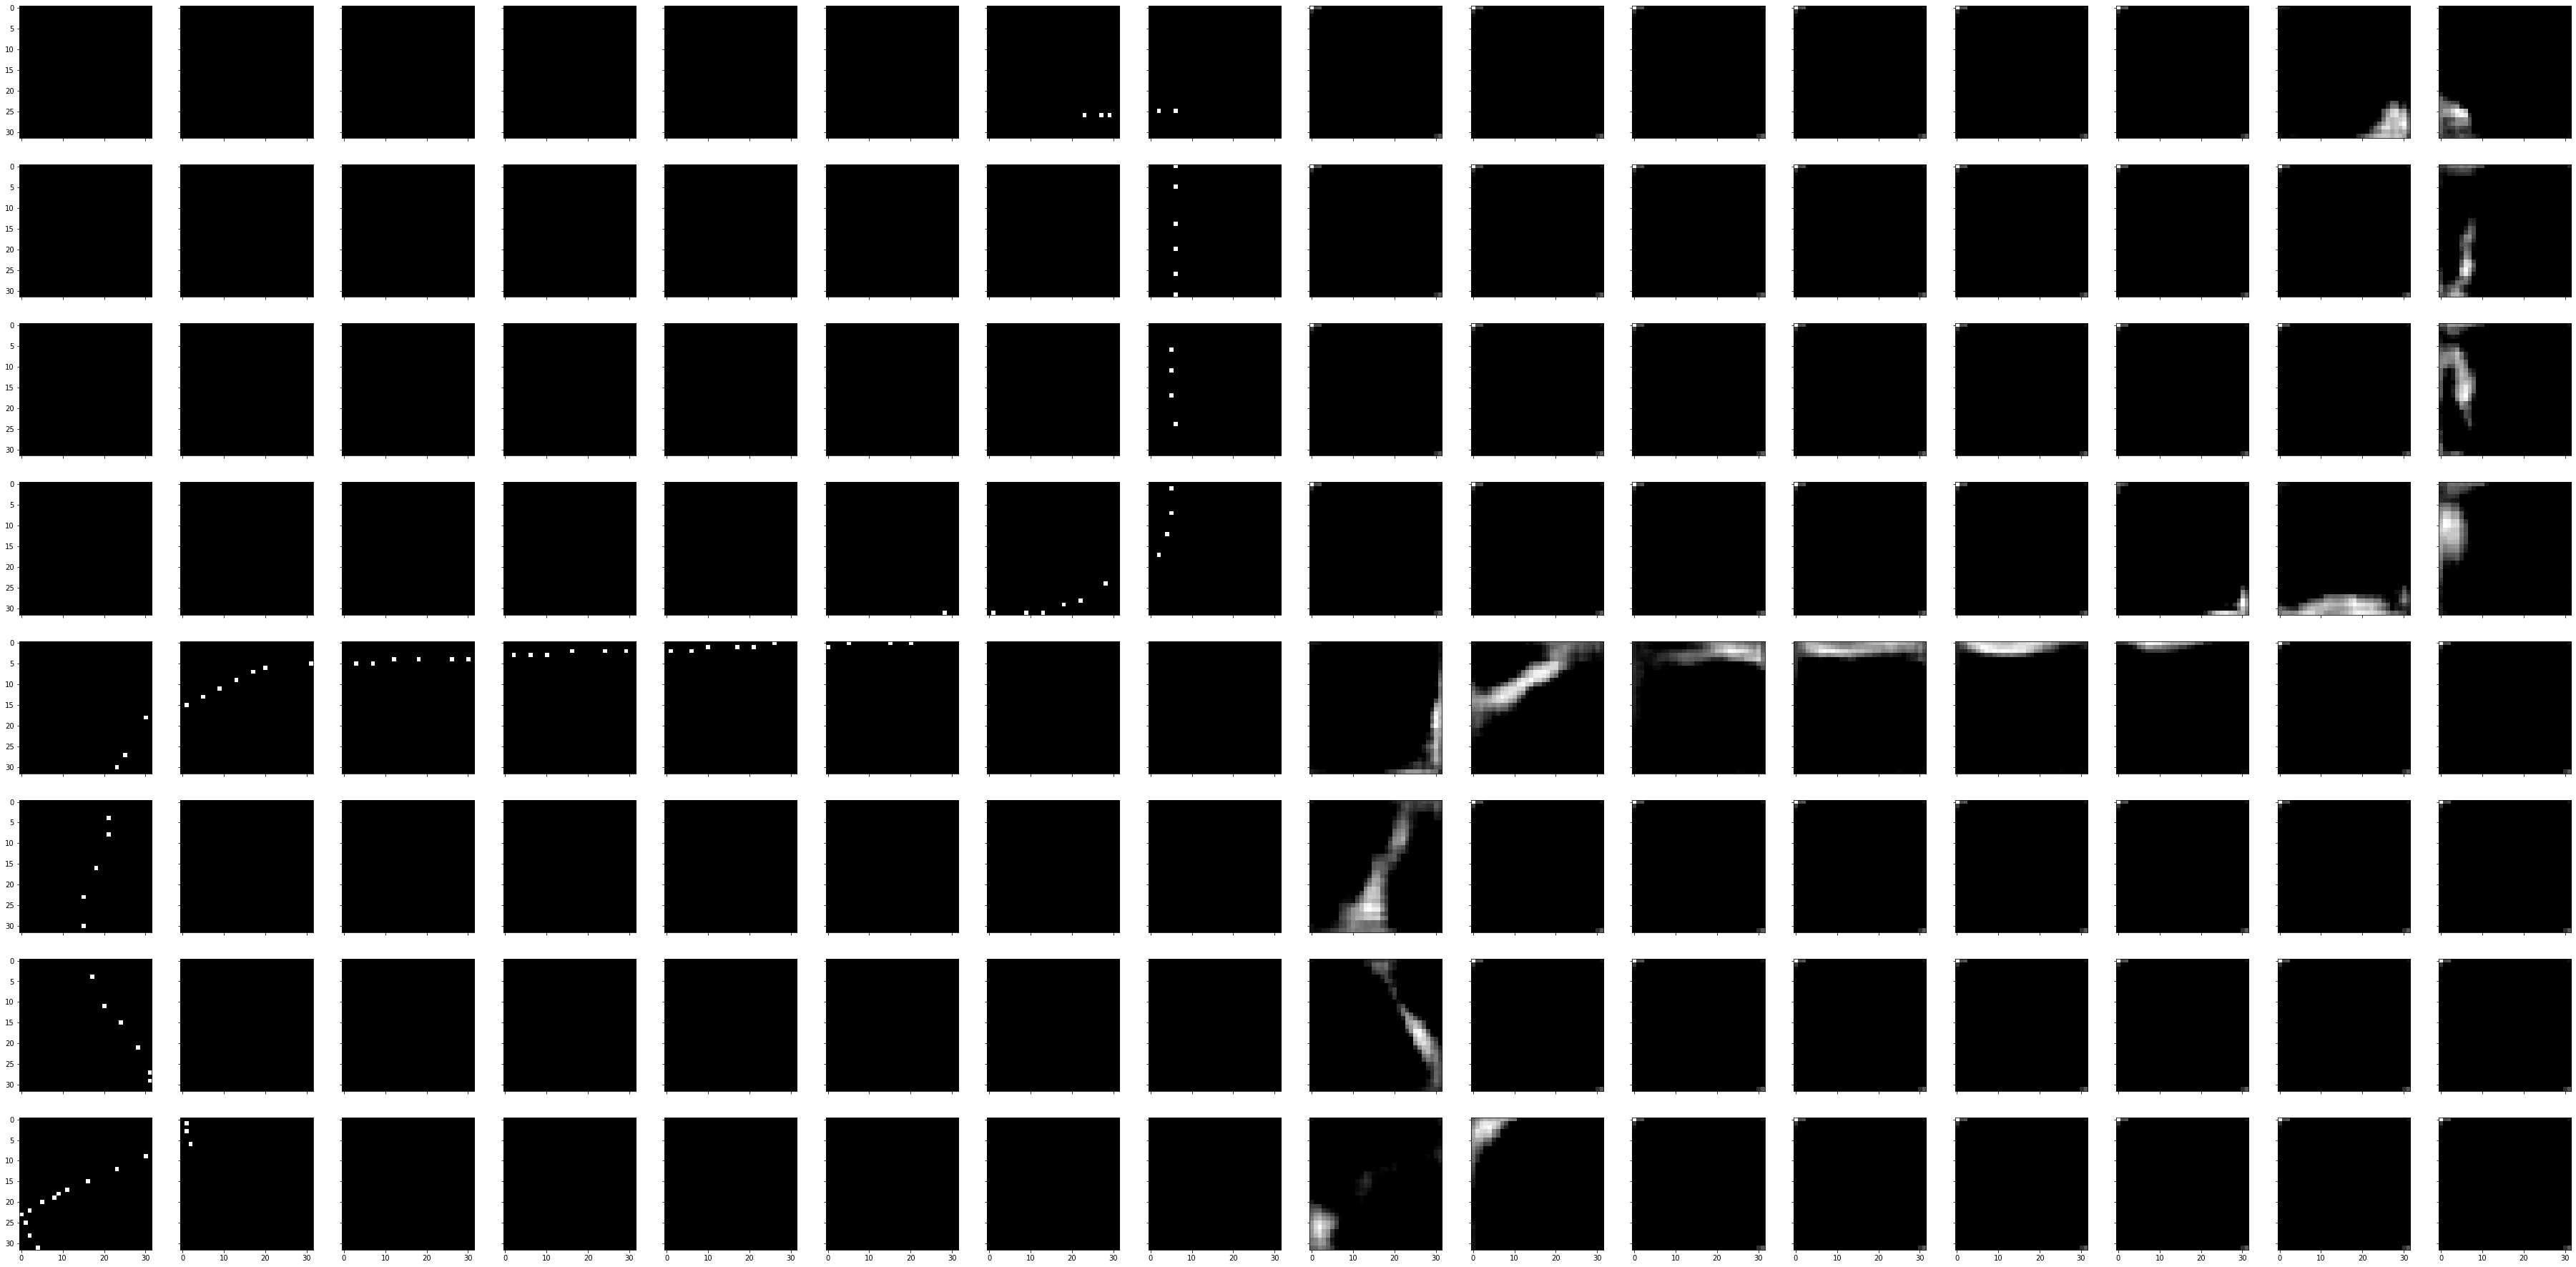

In [21]:
decoded_img = auto_encoder( X_test )

plt.gray()

row, col = HEIGHT // CROP_HEIGHT, WIDTH // CROP_WIDTH
n = row * col
fig, ax = plt.subplots( row, 2 * col, True, True, figsize = ( 64, 32 ) )
for i in range( n ):
    ax[i // 8][i % 8].imshow( X_test[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
    ax[i // 8][i % 8 + 8].imshow( tf.reshape( decoded_img[i], ( CROP_HEIGHT, CROP_WIDTH ) ) )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Reconstruction' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 100 )
plt.show()

## Calculate Cosine Similarity

In [22]:
# Cosine Similarity
from scipy.spatial import distance

threshold = 0.3
low_dimension_data = encoder( X_test )

Two trajectories are same


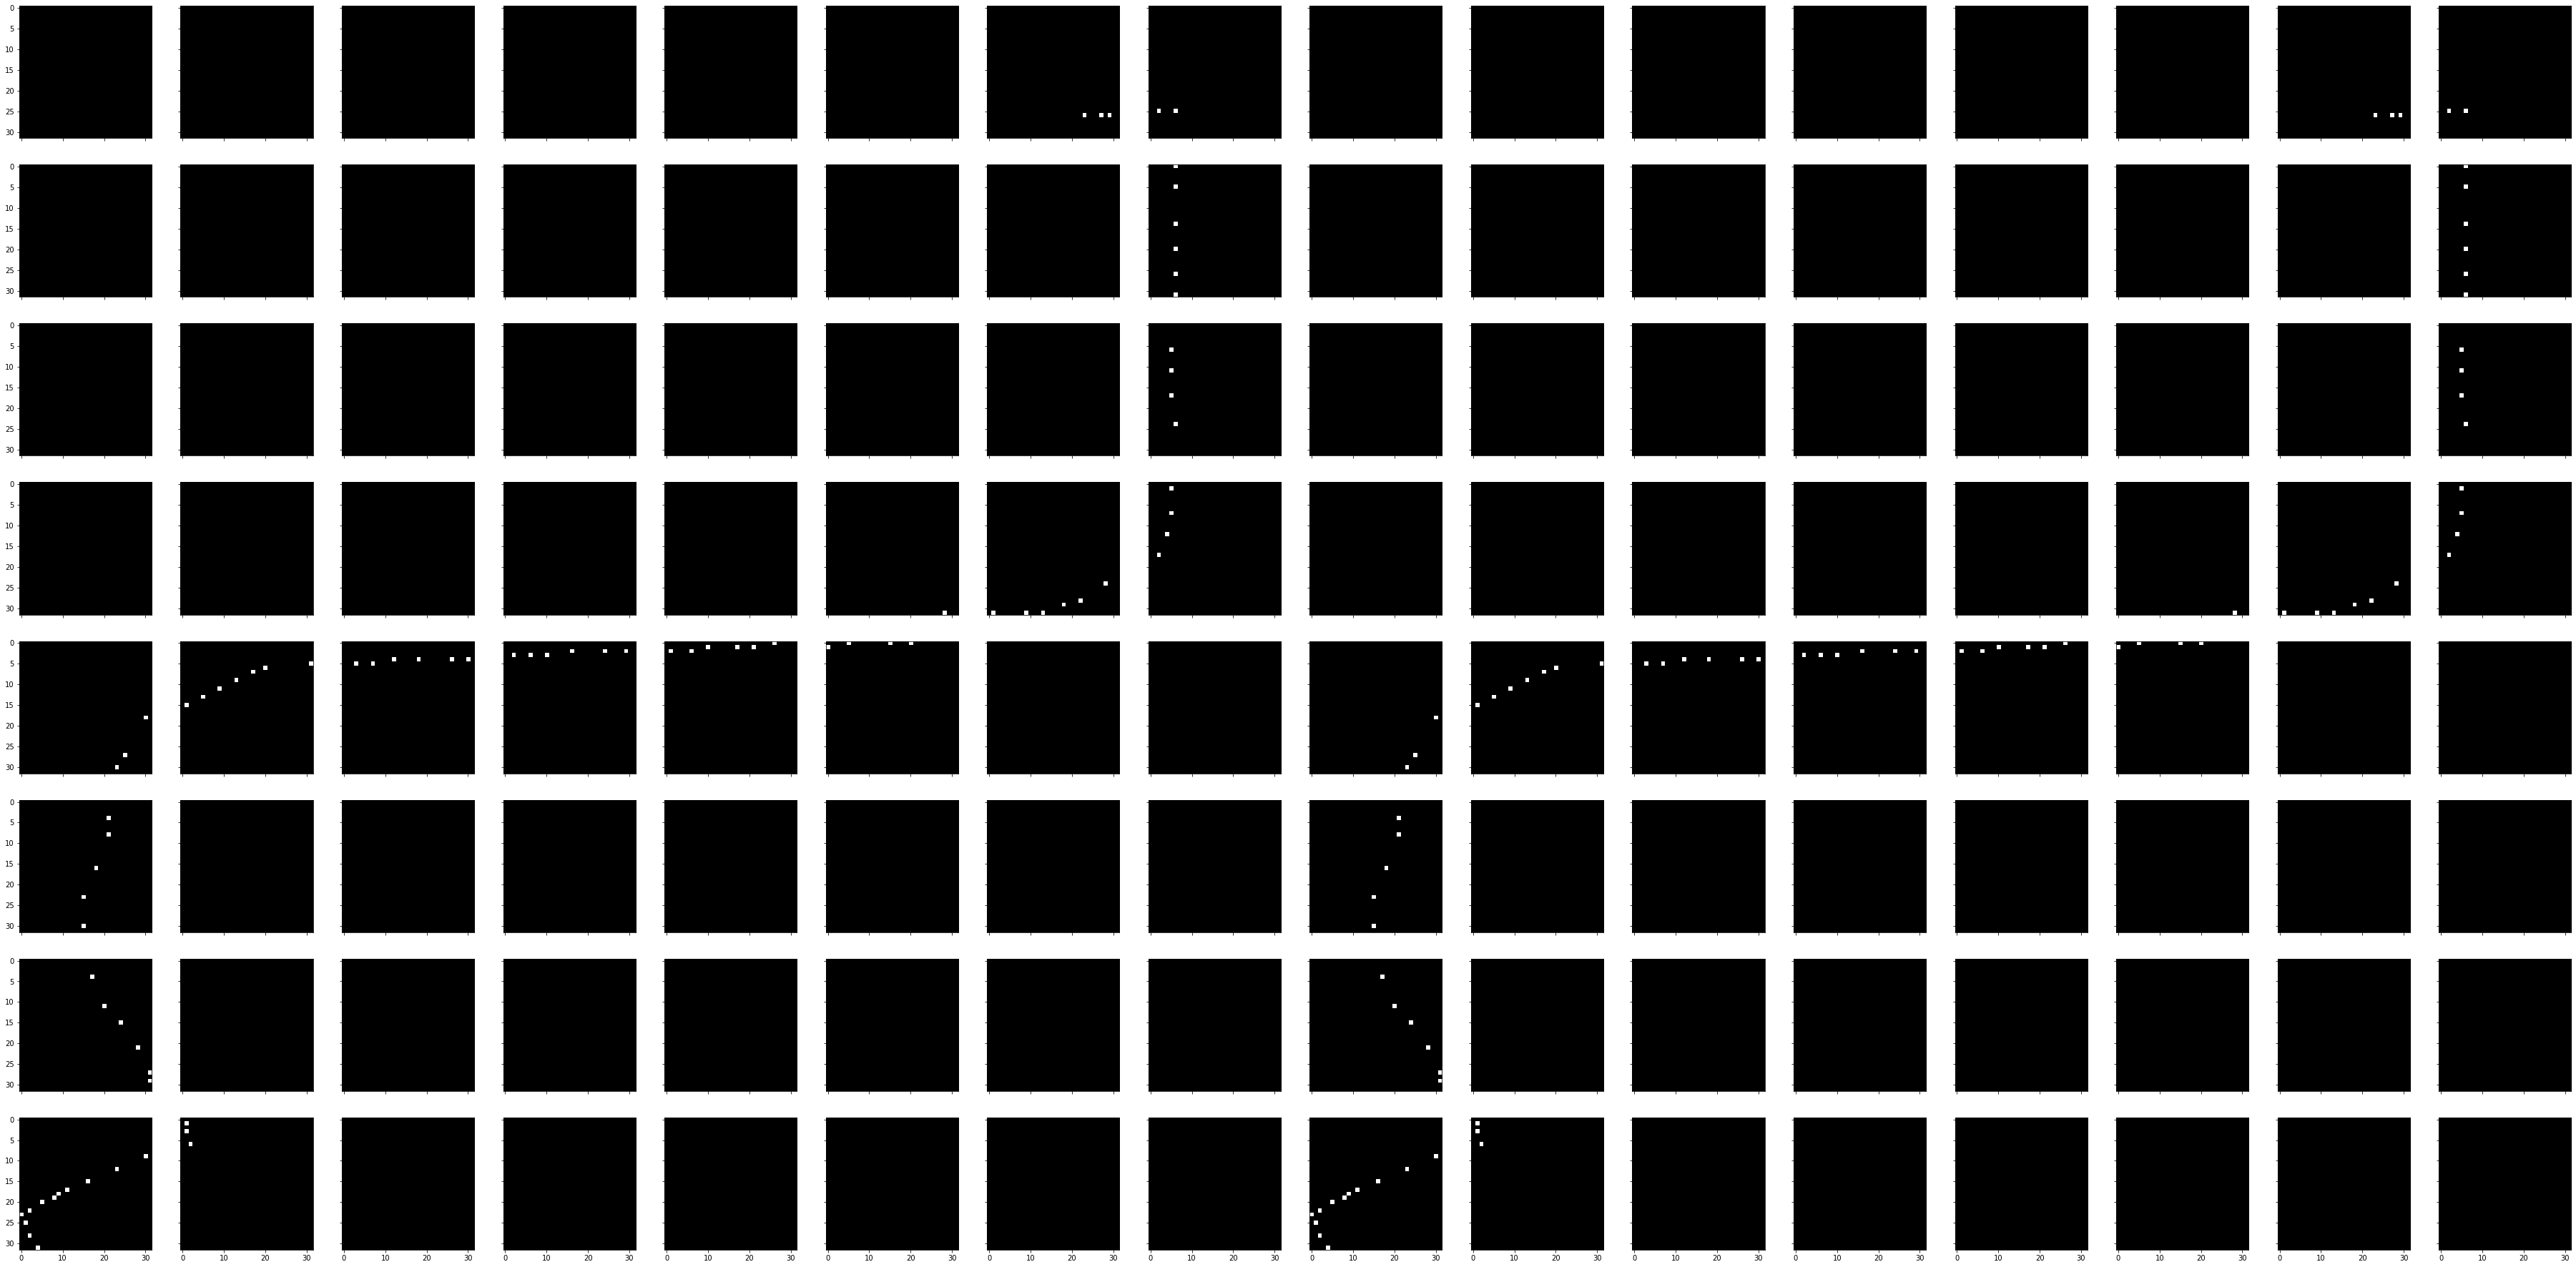

In [23]:
fig, ax = plt.subplots( 8, 16, True, True, figsize = ( 64, 32 ) )

idx, cnt = 0, 0
for i, j in zip( range( 0, 64 ), range( 0, 64 ) ):
    dist = distance.cosine( low_dimension_data[i], low_dimension_data[j] )
    if ( dist < threshold ):
        ax[idx // 8][idx % 8].imshow( X_test[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
        ax[idx // 8][idx % 8 + 8].imshow( X_test[j].reshape( CROP_HEIGHT, CROP_WIDTH ) )
        cnt += 1
    idx += 1

plt.savefig( f'intersection1_threhsold{threshold:.2f}.png', dpi = 100 )

print( 'Two trajectories are', end = ' ' )
if ( cnt <= 50 ):
    print( 'not', end = ' ' )
print( 'same' )

Two trajectories are same


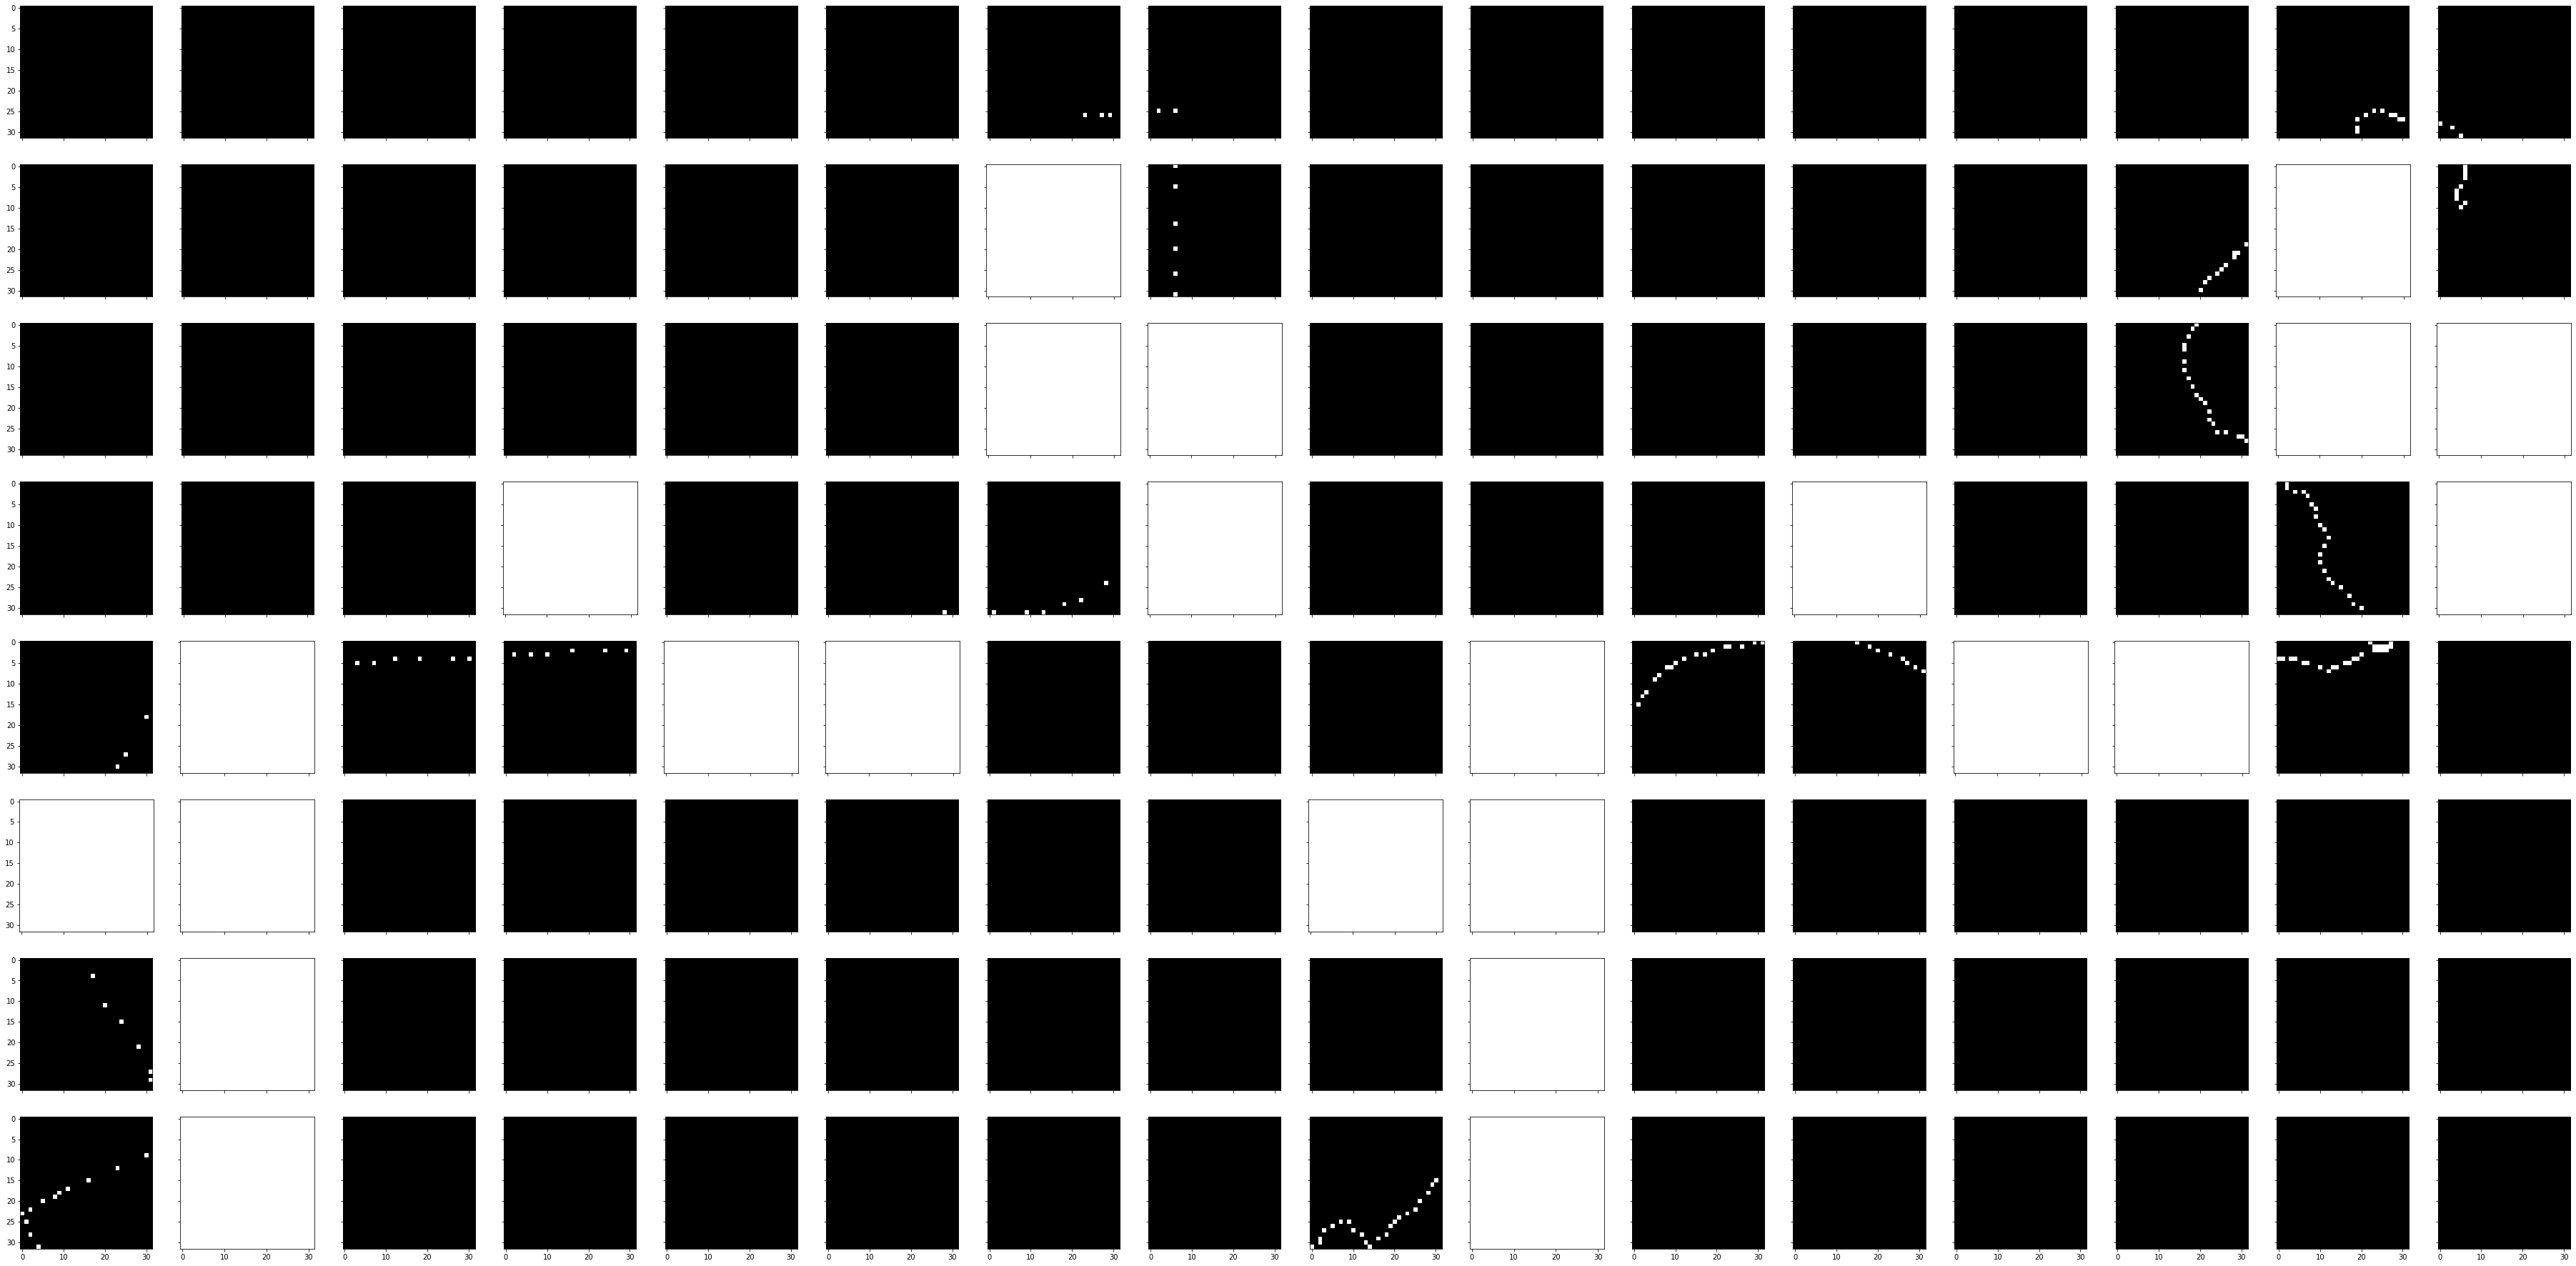

In [24]:
fig, ax = plt.subplots( 8, 16, True, True, figsize = ( 64, 32 ) )

idx, cnt = 0, 0
for i, j in zip( range( 0, 64 ), range( 128, 192 ) ):
    dist = distance.cosine( low_dimension_data[i], low_dimension_data[j] )
    if ( dist < threshold ):
        ax[idx // 8][idx % 8].imshow( X_test[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
        ax[idx // 8][idx % 8 + 8].imshow( X_test[j].reshape( CROP_HEIGHT, CROP_WIDTH ) )
        cnt += 1
    idx += 1

plt.savefig( f'intersection1_threhsold{threshold:.2f}.png', dpi = 100 )

print( 'Two trajectories are', end = ' ' )
if ( cnt <= 50 ):
    print( 'not', end = ' ' )
print( 'same' )

Two trajectories are not same


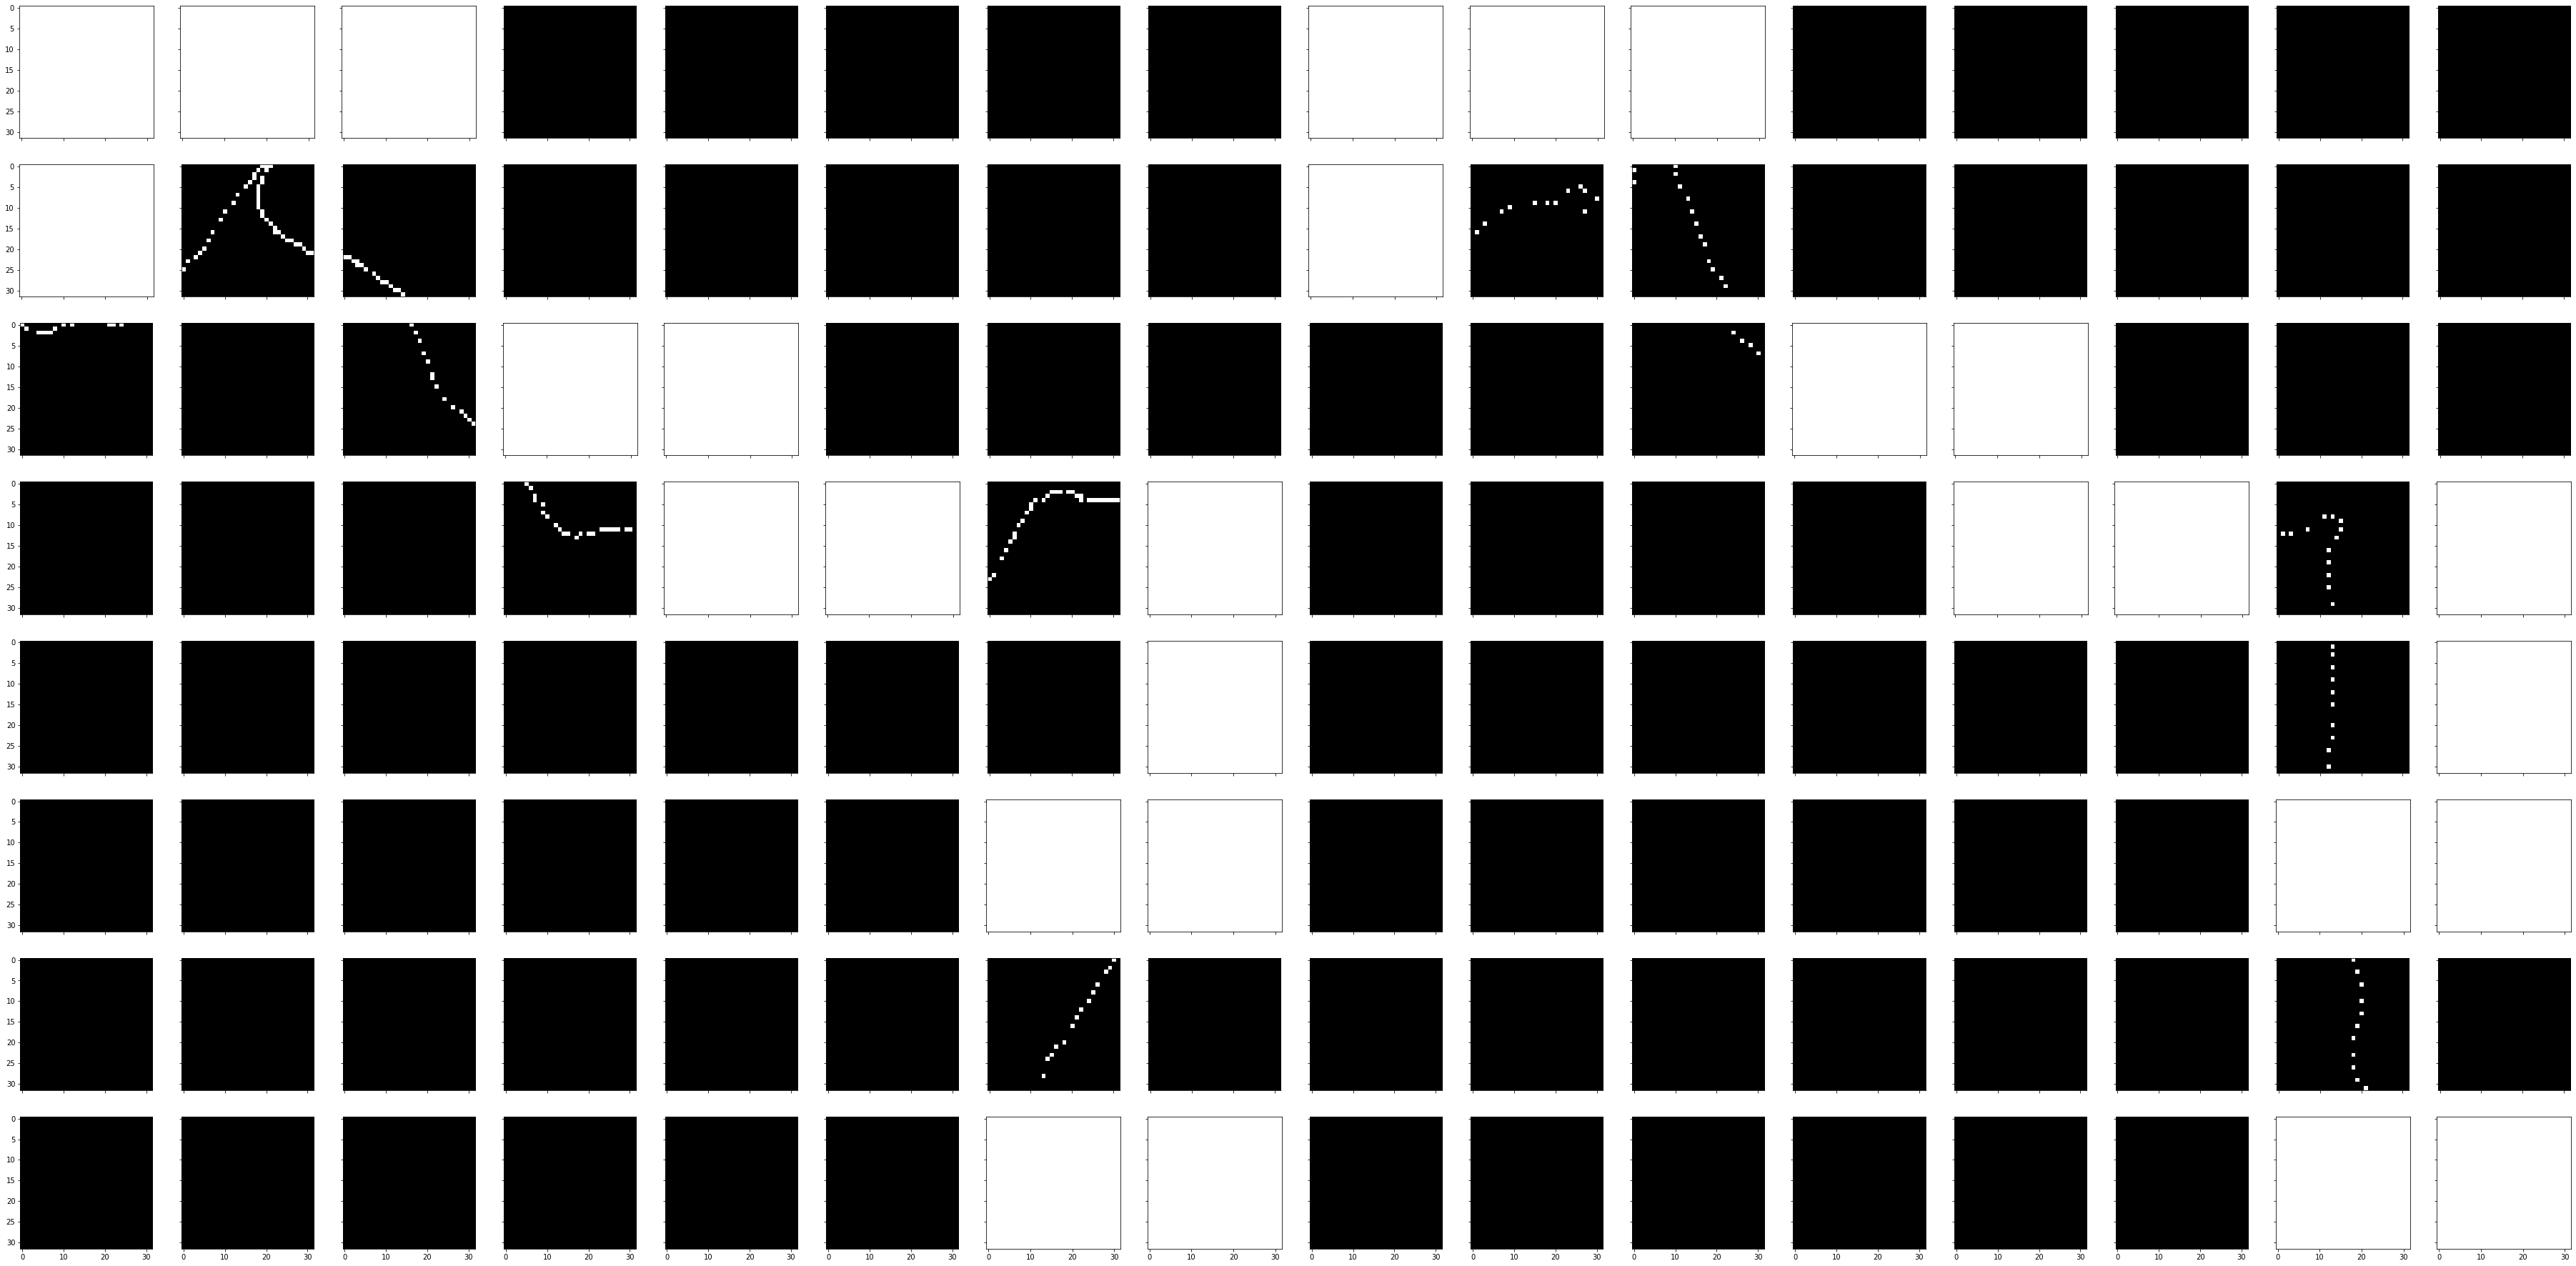

In [25]:
fig, ax = plt.subplots( 8, 16, True, True, figsize = ( 64, 32 ) )

idx, cnt = 0, 0
for i, j in zip( range( 64, 128 ), range( 192, 256 ) ):
    dist = distance.cosine( low_dimension_data[i], low_dimension_data[j] )
    if ( dist < threshold ):
        ax[idx // 8][idx % 8].imshow( X_test[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
        ax[idx // 8][idx % 8 + 8].imshow( X_test[j].reshape( CROP_HEIGHT, CROP_WIDTH ) )
        cnt += 1
    idx += 1

plt.savefig( f'intersection2_threhsold{threshold:.2f}.png', dpi = 100 )

print( 'Two trajectories are', end = ' ' )
if ( cnt <= 50 ):
    print( 'not', end = ' ' )
print( 'same' )

Two trajectories are not same


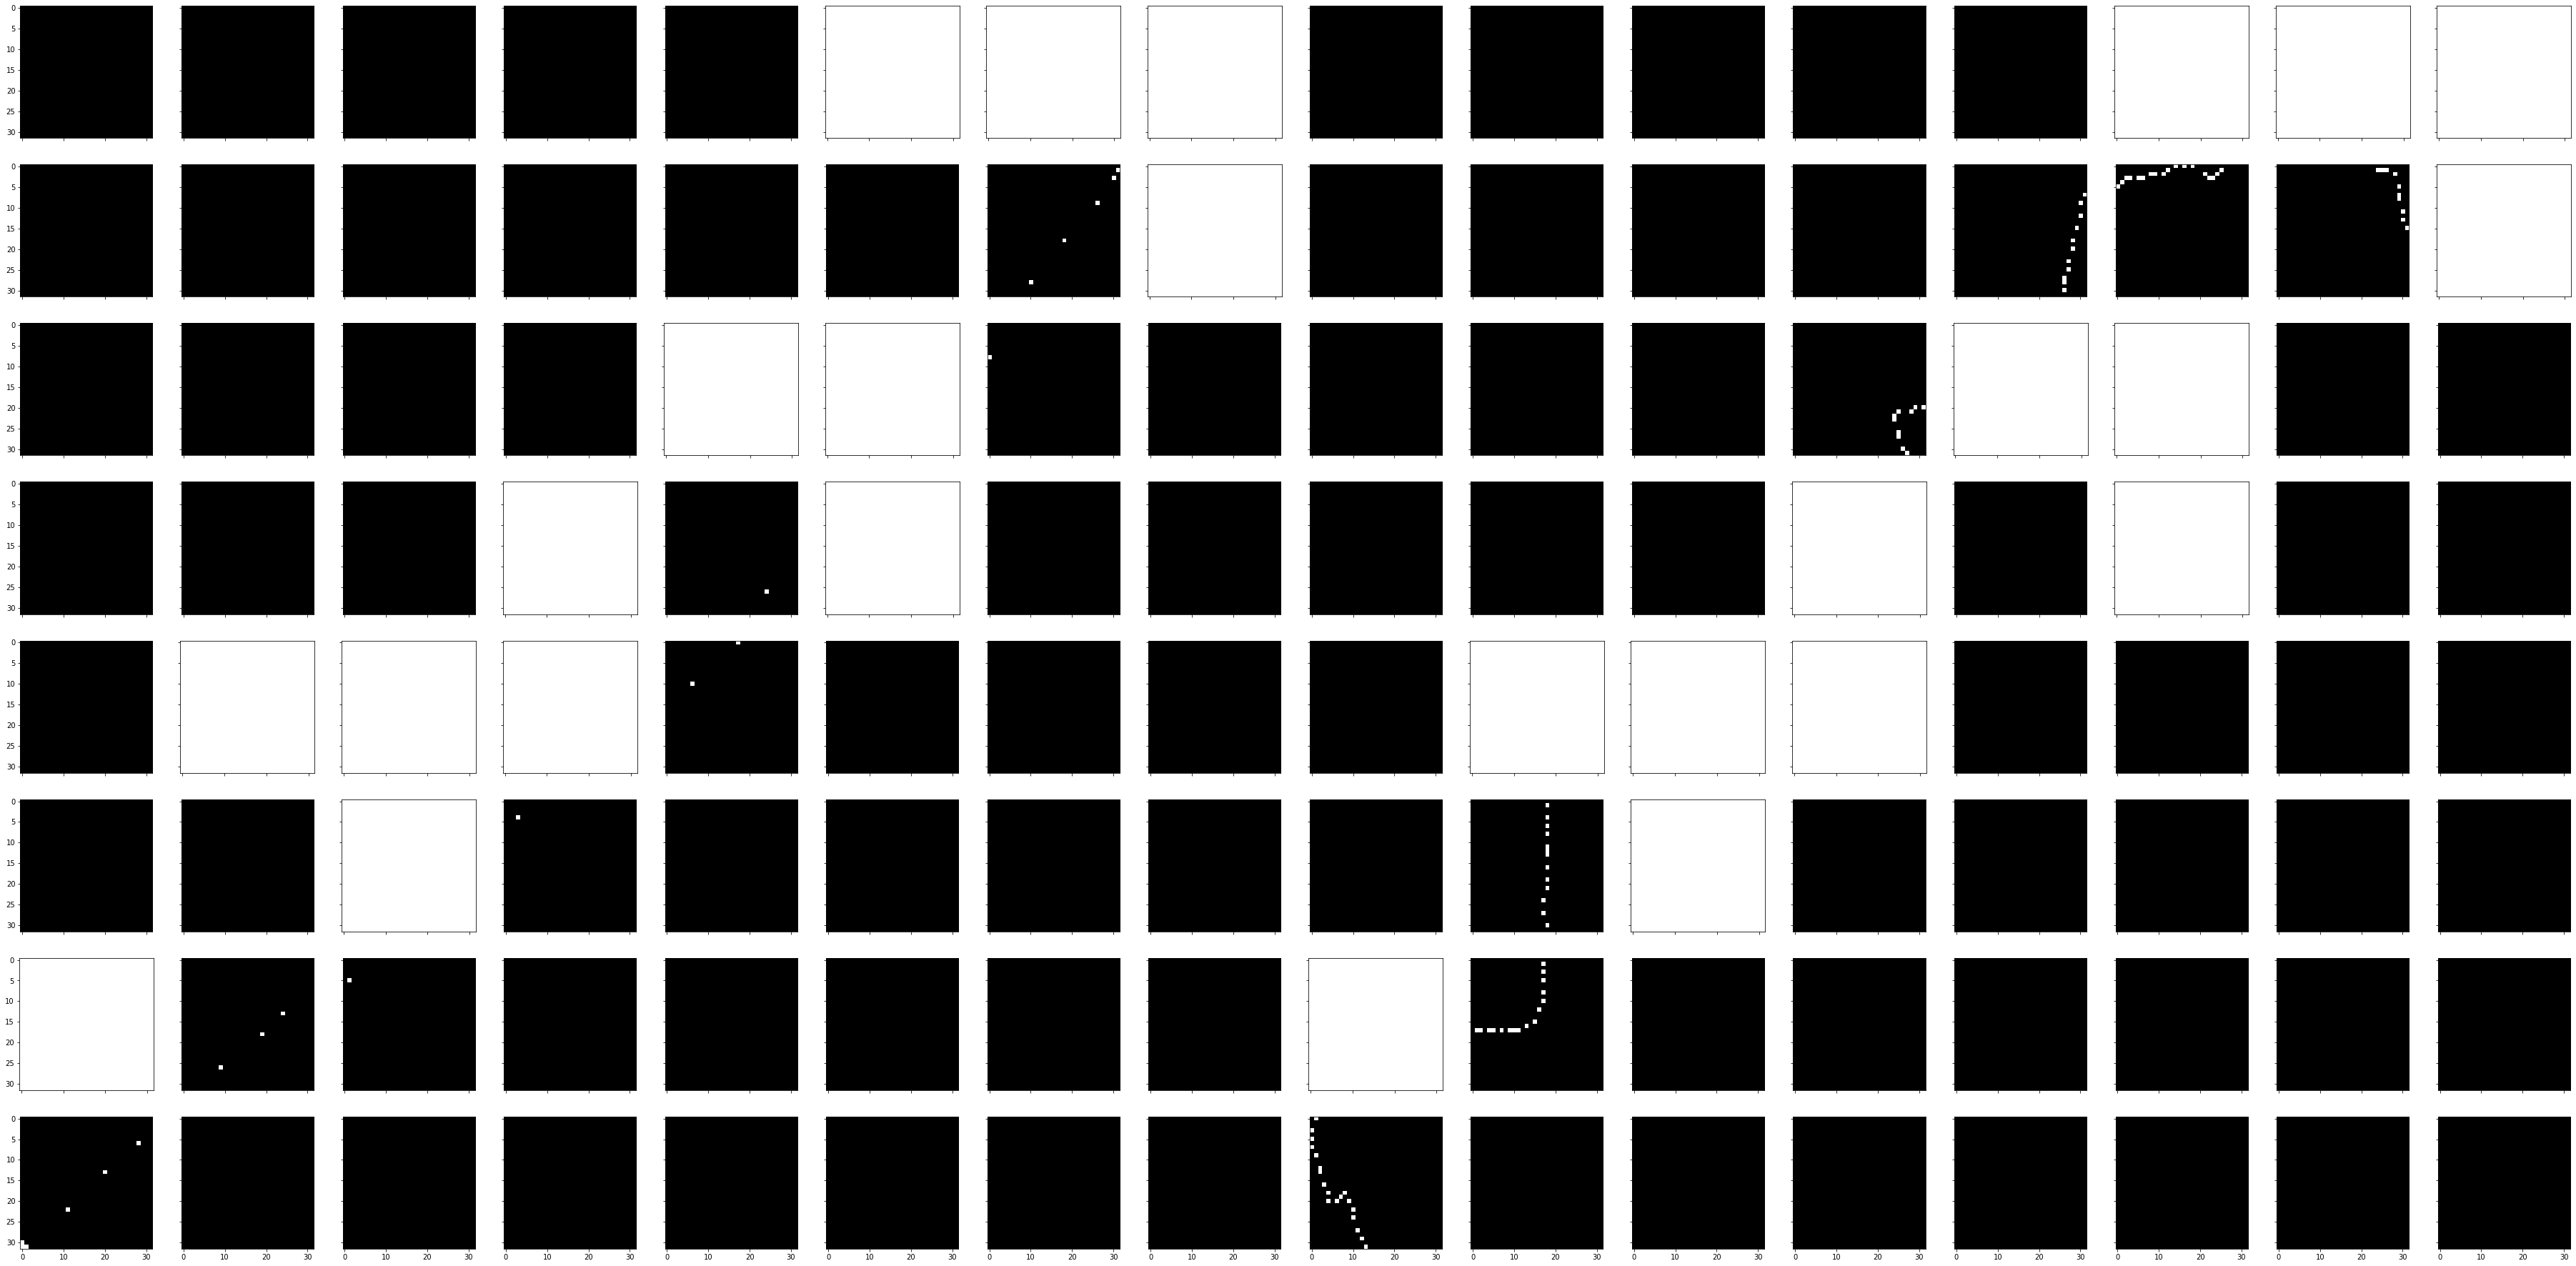

In [26]:
fig, ax = plt.subplots( 8, 16, True, True, figsize = ( 64, 32 ) )

idx, cnt = 0, 0
for i, j in zip( range( 256, 320 ), range( 320, 384 ) ):
    dist = distance.cosine( low_dimension_data[i], low_dimension_data[j] )
    if ( dist < threshold ):
        ax[idx // 8][idx % 8].imshow( X_test[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
        ax[idx // 8][idx % 8 + 8].imshow( X_test[j].reshape( CROP_HEIGHT, CROP_WIDTH ) )
    idx += 1

plt.savefig( f'intersection3_threhsold{threshold:.2f}.png', dpi = 100 )

print( 'Two trajectories are', end = ' ' )
if ( cnt <= 50 ):
    print( 'not', end = ' ' )
print( 'same' )